In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Set random seed for reproducibility
np.random.seed(42)

# Load the processed data
print("Loading and preparing data...")
df = pd.read_csv('processed_train_data_final.csv')

# Prepare features and target
feature_cols = [col for col in df.columns if col != 'Loan_Status']
X = df[feature_cols]
y = df['Loan_Status']  # Already encoded as 0 and 1

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Loading and preparing data...
Training set shape: (491, 21)
Testing set shape: (123, 21)


In [19]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    print(f"\n{model_name} Results:")
    print("="*50)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Approved', 'Approved'],
                yticklabels=['Not Approved', 'Approved'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    return {
        'accuracy': accuracy,
        'classification_report': report,
        'confusion_matrix': conf_matrix,
        'roc_auc': roc_auc
    }


In [20]:
def plot_feature_importance(model, feature_names, model_name):
    importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance, x='importance', y='feature')
    plt.title(f'Feature Importance - {model_name}')
    plt.show()

    return importance


Training Decision Tree Model...
Best Decision Tree Parameters:
{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10}

Decision Tree Results:
Accuracy: 0.8049

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.71      0.69        38
           1       0.87      0.85      0.86        85

    accuracy                           0.80       123
   macro avg       0.77      0.78      0.77       123
weighted avg       0.81      0.80      0.81       123



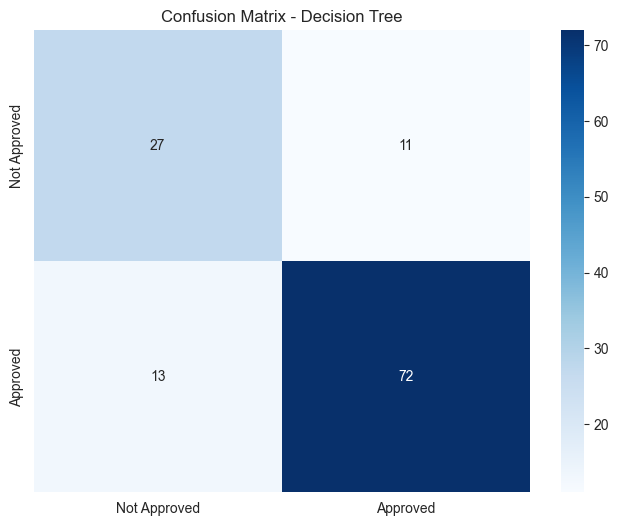

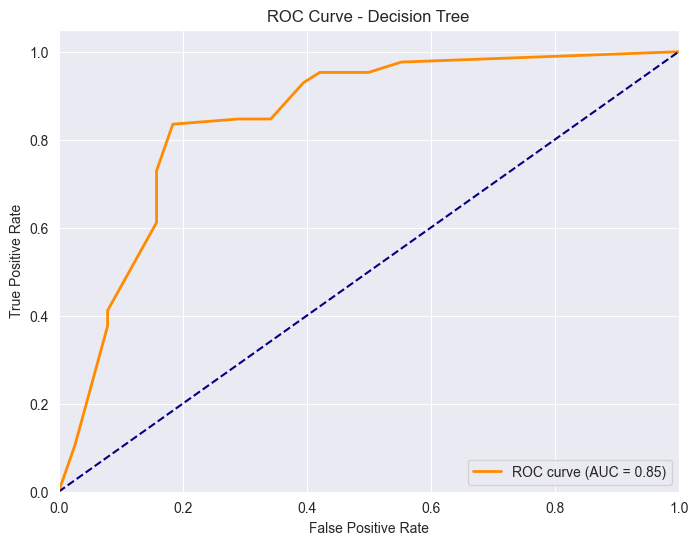

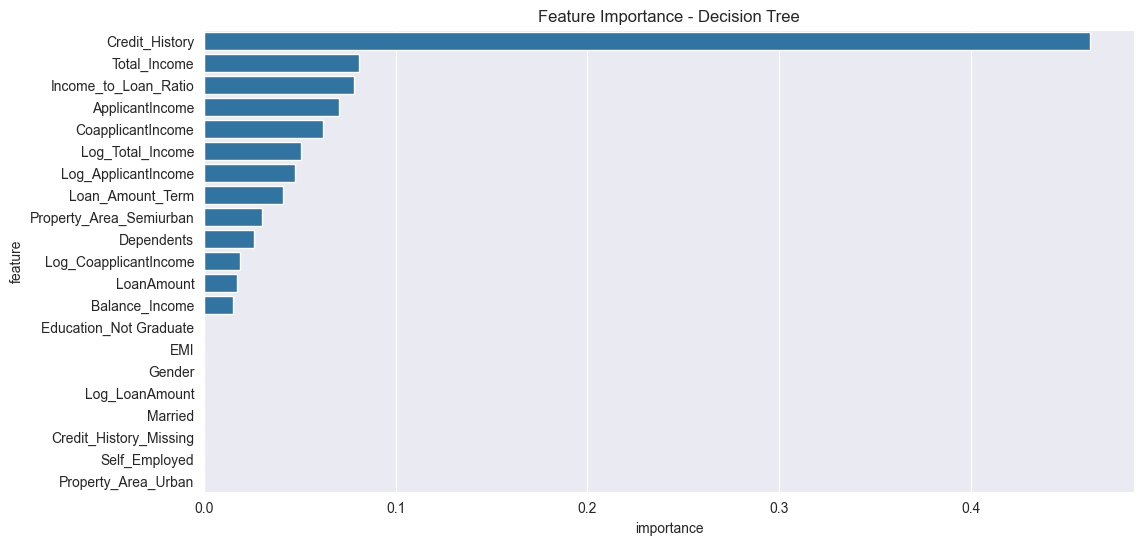

In [29]:
from sklearn.tree import DecisionTreeClassifier

print("\nTraining Decision Tree Model...")
dt_params = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)
dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='roc_auc', n_jobs=-1)
dt_grid.fit(X_train, y_train)

print("Best Decision Tree Parameters:")
print(dt_grid.best_params_)
dt_results = evaluate_model(dt_grid.best_estimator_, X_test, y_test, "Decision Tree")
dt_importance = plot_feature_importance(dt_grid.best_estimator_, feature_cols, "Decision Tree")


Training Random Forest Model...
Best Random Forest Parameters:
{'max_depth': 9, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}

Random Forest Results:
Accuracy: 0.8780

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.71      0.78        38
           1       0.88      0.95      0.92        85

    accuracy                           0.88       123
   macro avg       0.88      0.83      0.85       123
weighted avg       0.88      0.88      0.87       123



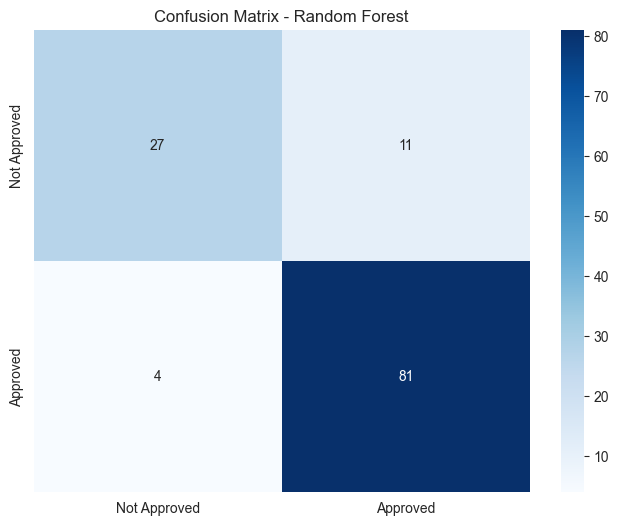

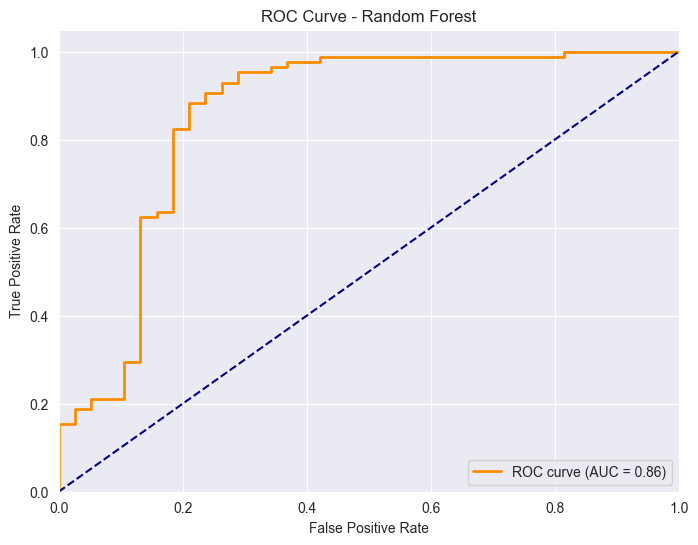

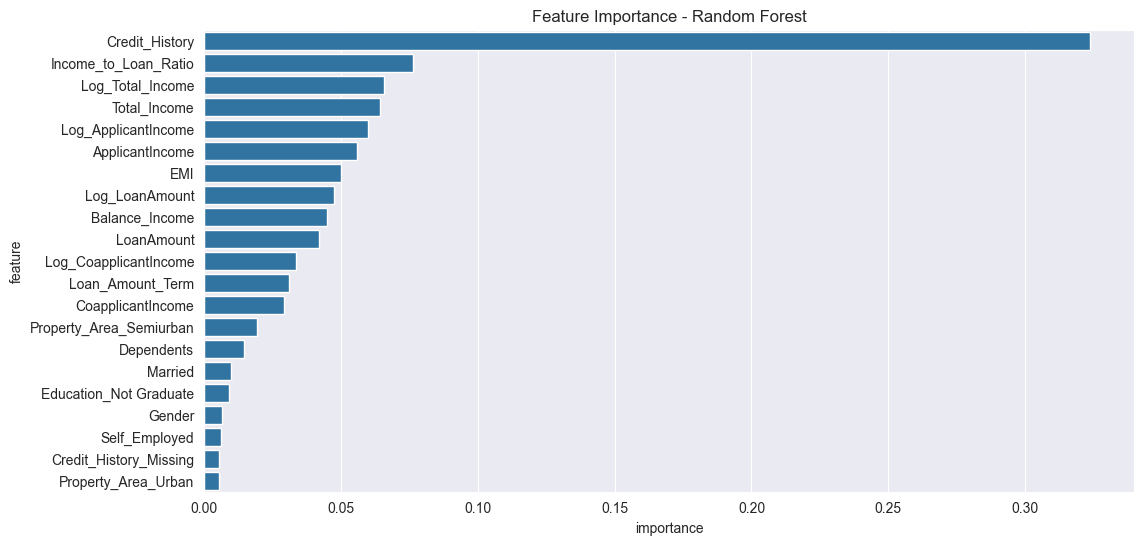

In [22]:
from sklearn.ensemble import RandomForestClassifier

print("\nTraining Random Forest Model...")
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print("Best Random Forest Parameters:")
print(rf_grid.best_params_)
rf_results = evaluate_model(rf_grid.best_estimator_, X_test, y_test, "Random Forest")
rf_importance = plot_feature_importance(rf_grid.best_estimator_, feature_cols, "Random Forest")


Training Gradient Boosting Model...
Best Gradient Boosting Parameters:
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}

Gradient Boosting Results:
Accuracy: 0.7805

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.61      0.63        38
           1       0.83      0.86      0.84        85

    accuracy                           0.78       123
   macro avg       0.74      0.73      0.74       123
weighted avg       0.78      0.78      0.78       123



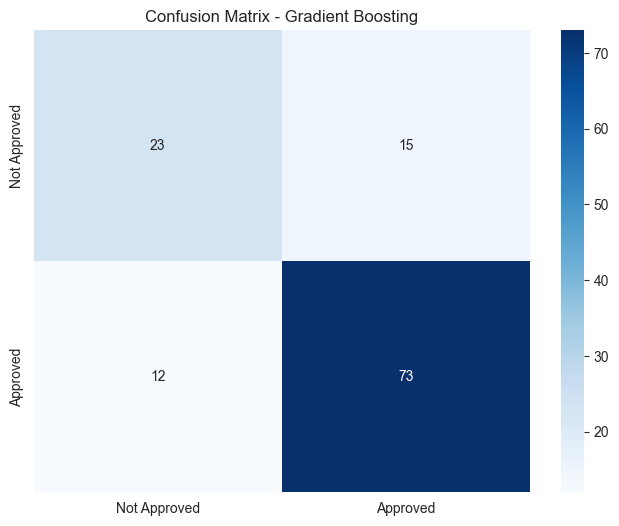

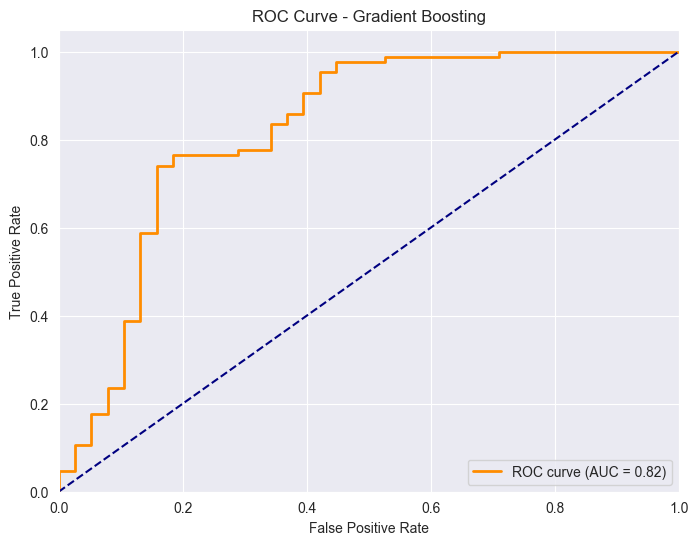

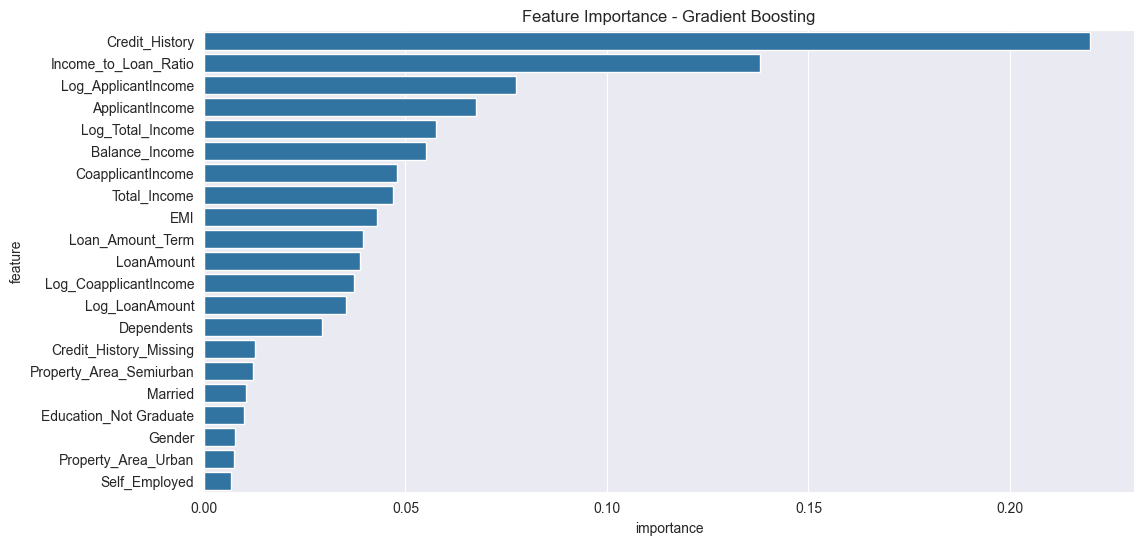

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

print("\nTraining Gradient Boosting Model...")
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

gb = GradientBoostingClassifier(random_state=42)
gb_grid = GridSearchCV(gb, gb_params, cv=5, scoring='roc_auc', n_jobs=-1)
gb_grid.fit(X_train, y_train)

print("Best Gradient Boosting Parameters:")
print(gb_grid.best_params_)
gb_results = evaluate_model(gb_grid.best_estimator_, X_test, y_test, "Gradient Boosting")
gb_importance = plot_feature_importance(gb_grid.best_estimator_, feature_cols, "Gradient Boosting")


Model Comparison:
               Model  Accuracy   ROC AUC
0      Decision Tree  0.804878  0.847833
1      Random Forest  0.878049  0.855418
2  Gradient Boosting  0.780488  0.823529


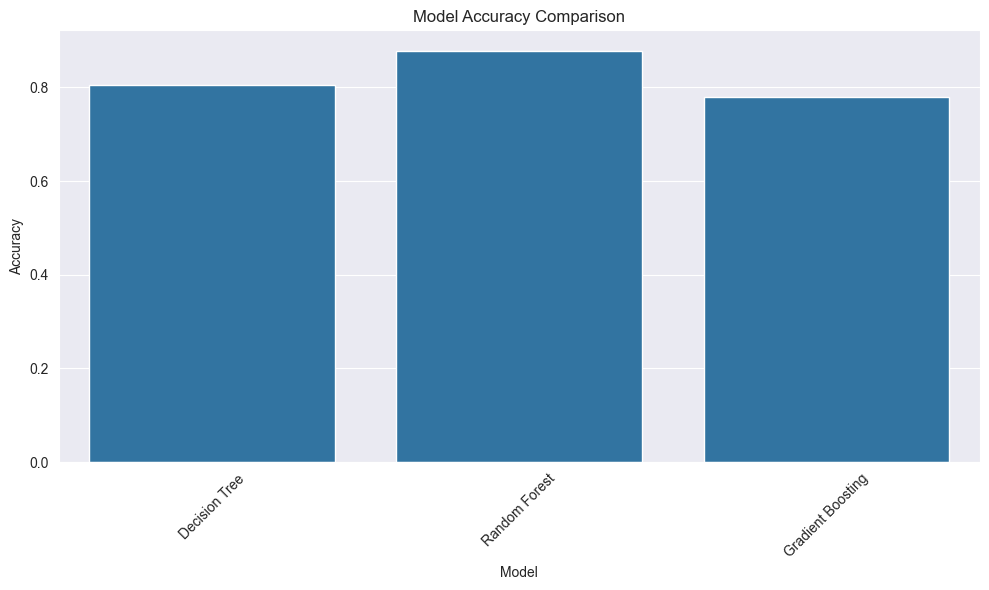

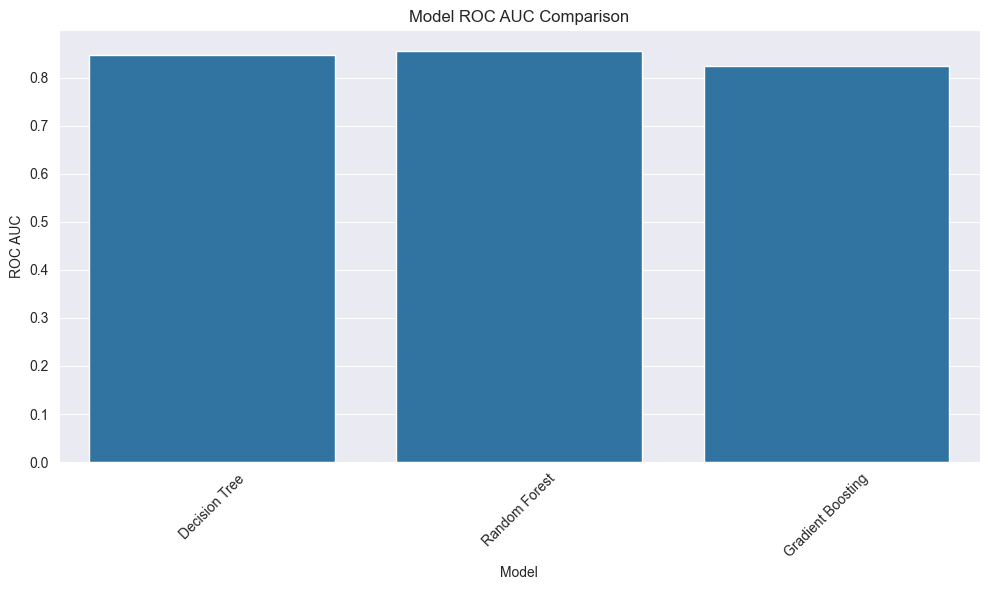

In [25]:
# Compare models
model_comparison = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [dt_results['accuracy'], rf_results['accuracy'], gb_results['accuracy']],
    'ROC AUC': [dt_results['roc_auc'], rf_results['roc_auc'], gb_results['roc_auc']]
})

print("\nModel Comparison:")
print(model_comparison)

# Plot model comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=model_comparison)
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='ROC AUC', data=model_comparison)
plt.title('Model ROC AUC Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
# Save results
model_comparison.to_csv('model_comparison_results.csv', index=False)

In [30]:
# At the end of Phase 2, add this code to save the models
import os
import joblib

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the trained models
model_dict = {
    'Decision Tree': dt_grid.best_estimator_,
    'Random Forest': rf_grid.best_estimator_,
    'Gradient Boosting': gb_grid.best_estimator_
}

# Save each model
for name, model in model_dict.items():
    filename = f"models/{name.lower().replace(' ', '_')}.joblib"
    joblib.dump(model, filename)
    print(f"Saved {name} model to {filename}")

Saved Decision Tree model to models/decision_tree.joblib
Saved Random Forest model to models/random_forest.joblib
Saved Gradient Boosting model to models/gradient_boosting.joblib
